# GEOG696C Spatiotemporal Data Analytics: Term Project
## calcEOF_FIA.ipynb
This script reads in the FIA data - extracted in the code "extractPixelFIATimeSeries.ipynb" - and performs EOF and rotated EOF, with significance testing.

In [43]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import math
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import rioxarray as rx
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import scipy as sp
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter

In [2]:
# Set the root path
# rootPath = Path('/media/mule/Projects/NASA/NIP/Data')
rootPath = Path('C:/Users/alexsaunders/Documents/01_uoa/01_study/2023/geog696c/project/data')

In [3]:
font_dirs = ['C:/users/alexsaunders/appdata/local/microsoft/windows/fonts']
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    mpl.font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Work Sans'

## 1) Load the FIA data with xarray
8-day timesteps from 2001-2022 (ntime=985), for (1346, 1040) (nloc=1399840) 500 m resolution pixels across Bangladesh

In [4]:
# dataPath = rootPath/'Models/DeepLearning/Inference/CrossValidation/Archive/Historical/Ensemble'
# dataPath = Path('C:/Users/alexsaunders/Documents/01_uoa/02_ra/01_projects/01_nip/02_hysteresis/inTmp') # local copy
dataPath = Path('Z:/media/mule/Projects/NASA/NIP/Data/Models/DeepLearning/Inference/CrossValidation/FullRaster/Ensemble')
dataFiles = [file for file in list(dataPath.iterdir()) if file.suffix=='.tiff']

In [5]:
print(len(dataFiles))

985


### Get the dimensions

In [6]:
# Open a single raster and get the spatial dimensions
file = dataFiles[0]
raster = rio.open(file)
rasterData = raster.read(1)
print(rasterData.shape, rasterData.shape[0]*rasterData.shape[1])

(1346, 1040) 1399840


In [7]:
# Save the dimensions we want
ntime, nrow, ncol = len(dataFiles), rasterData.shape[0], rasterData.shape[1]
print(ntime, nrow, ncol)

985 1346 1040


### Get the raster pixel data for all dates to create time series for each pixel - load with xarray

In [8]:
# Get the dates of all the raster files
imageDates=[]
# Loop through the tif files
for f, file in enumerate(dataFiles):
    # Get the data of the image
    imageDate = datetime.fromtimestamp(int(file.stem[:-3])).strftime('%Y%m%d')
    imageDates.append(imageDate)
imageDates=pd.to_datetime(imageDates)

In [9]:
# Sort the files in date order, since using their unix ms time they are not in order
sortIdx = imageDates.argsort()
dataFiles=[dataFiles[i] for i in sortIdx]
imageDates=imageDates.sort_values()

In [10]:
# Get the raster pixel coordinates
file = dataFiles[0]
with rio.open(file) as src:
    band1 = src.read(1)
    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(src.transform, rows, cols)
    lons = np.array(xs)
    lats = np.array(ys)
    
lat=np.array([item[0] for item in lats])
lon=lons[0]

print(lat.shape, lon.shape)

(1346,) (1040,)


In [11]:
# Create empty array for storing the values
rasterDataAllDates = np.zeros([nrow, ncol, ntime])

# Loop through files and for each one, record the pixel value into an array with values for the same pixel from all other dates
# Loop through the tif files
for f, file in enumerate(dataFiles):
    # Open and get raster values
    with rio.open(file) as raster:
        # Assign raster values to array
        rasterDataAllDates[:,:,f]=raster.read(1)

In [12]:
print(rasterDataAllDates.shape)

(1346, 1040, 985)


In [13]:
# Convert to xarray data array
FIAxr = xr.DataArray(
    rasterDataAllDates,
    coords={'lat': lat, 'lon': lon, 'time': imageDates},
    dims=['lat', 'lon', 'time']
)

In [14]:
# Save as a netcdf for ease of loading in again later
outPath= rootPath/'pixelFIA/xr/'
outPath.mkdir(exist_ok=True)
FIAxr.to_netcdf(outPath/'pixelFIACountry.nc')

In [15]:
# Read in from nc file
xrPath=rootPath/'pixelFIA/xr/'
FIAxr = xr.open_dataarray(xrPath/'pixelFIACountry.nc')

In [17]:
FIAxrOld = xr.open_dataarray(xrPath/'pixelFIA.nc')

In [18]:
FIAxrOld

<xarray.DataArray (lat: 1346, lon: 1040, time: 985)>
[1378842400 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 26.63 26.63 26.62 26.62 ... 20.61 20.6 20.6 20.59
  * lon      (lon) float64 88.01 88.01 88.02 88.02 ... 92.66 92.67 92.67 92.68
  * time     (time) datetime64[ns] 2001-06-13 2001-06-29 ... 2022-12-30

In [16]:
FIAxr

<xarray.DataArray (lat: 1346, lon: 1040, time: 985)>
[1378842400 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 26.63 26.63 26.62 26.62 ... 20.61 20.6 20.6 20.59
  * lon      (lon) float64 88.01 88.01 88.02 88.02 ... 92.66 92.67 92.67 92.68
  * time     (time) datetime64[ns] 2001-06-13 2001-06-29 ... 2022-12-30

### Coarsen to 11* lower resolution, same as precip data, for computational ease

In [23]:
FIA_highres=FIA.copy()

In [24]:
resFactor=11
FIA = FIA.coarsen(lat=resFactor, boundary='trim').mean().coarsen(lon=resFactor, boundary='trim').mean()

In [25]:
# Save as netcdf for easy loading
FIA.to_netcdf(outPath/'pixelFIACountryCoarse.nc')

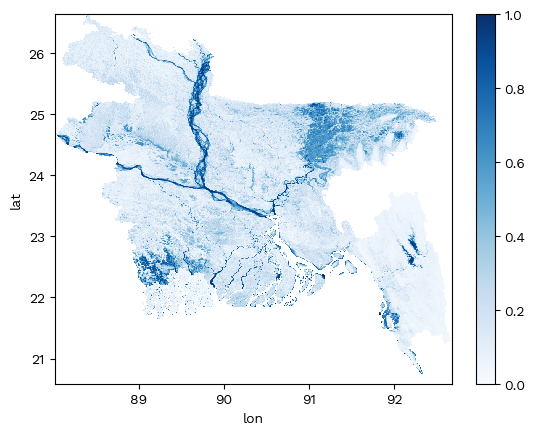

In [29]:
cmap='Blues'
vmin, vmax = 0,1
FIA_highres.mean(dim="time").plot(cmap=cmap, vmin=vmin, vmax=vmax)
plt.show()

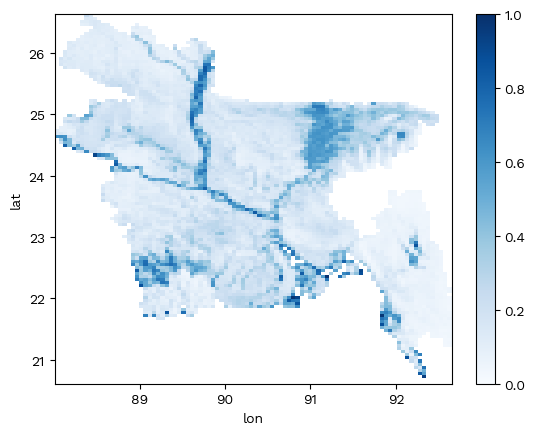

In [30]:
cmap='Blues'
vmin, vmax = 0,1
FIA.mean(dim="time").plot(cmap=cmap, vmin=vmin, vmax=vmax)
plt.show()

In [36]:
FIA.shape[0]*FIA.shape[1]

11468

In [35]:
FIA_highres.shape[0]*FIA_highres.shape[1]

1399840

### Plot the long-term average of the monthly max FIA

In [41]:
# Function to get the extend argument
def getExtend(amin, amax, vmin, vmax):
    if amin<vmin and amax<=vmax:
        extend='min'
    elif amax>vmax and amin>=vmin:
        extend='max'
    elif amin<vmin and amax>vmax:
        extend='both'
    else:
        extend='neither'
    return extend

In [49]:
FIAMonthlyMax=FIA.resample(time='1M', skipna=True).max(dim='time')
FIAMonthlyClim = FIAMonthlyMax.groupby('time.month').mean(dim='time')

In [50]:
monthNames=[item[:3] for item in list(calendar.month_name)[1:]]

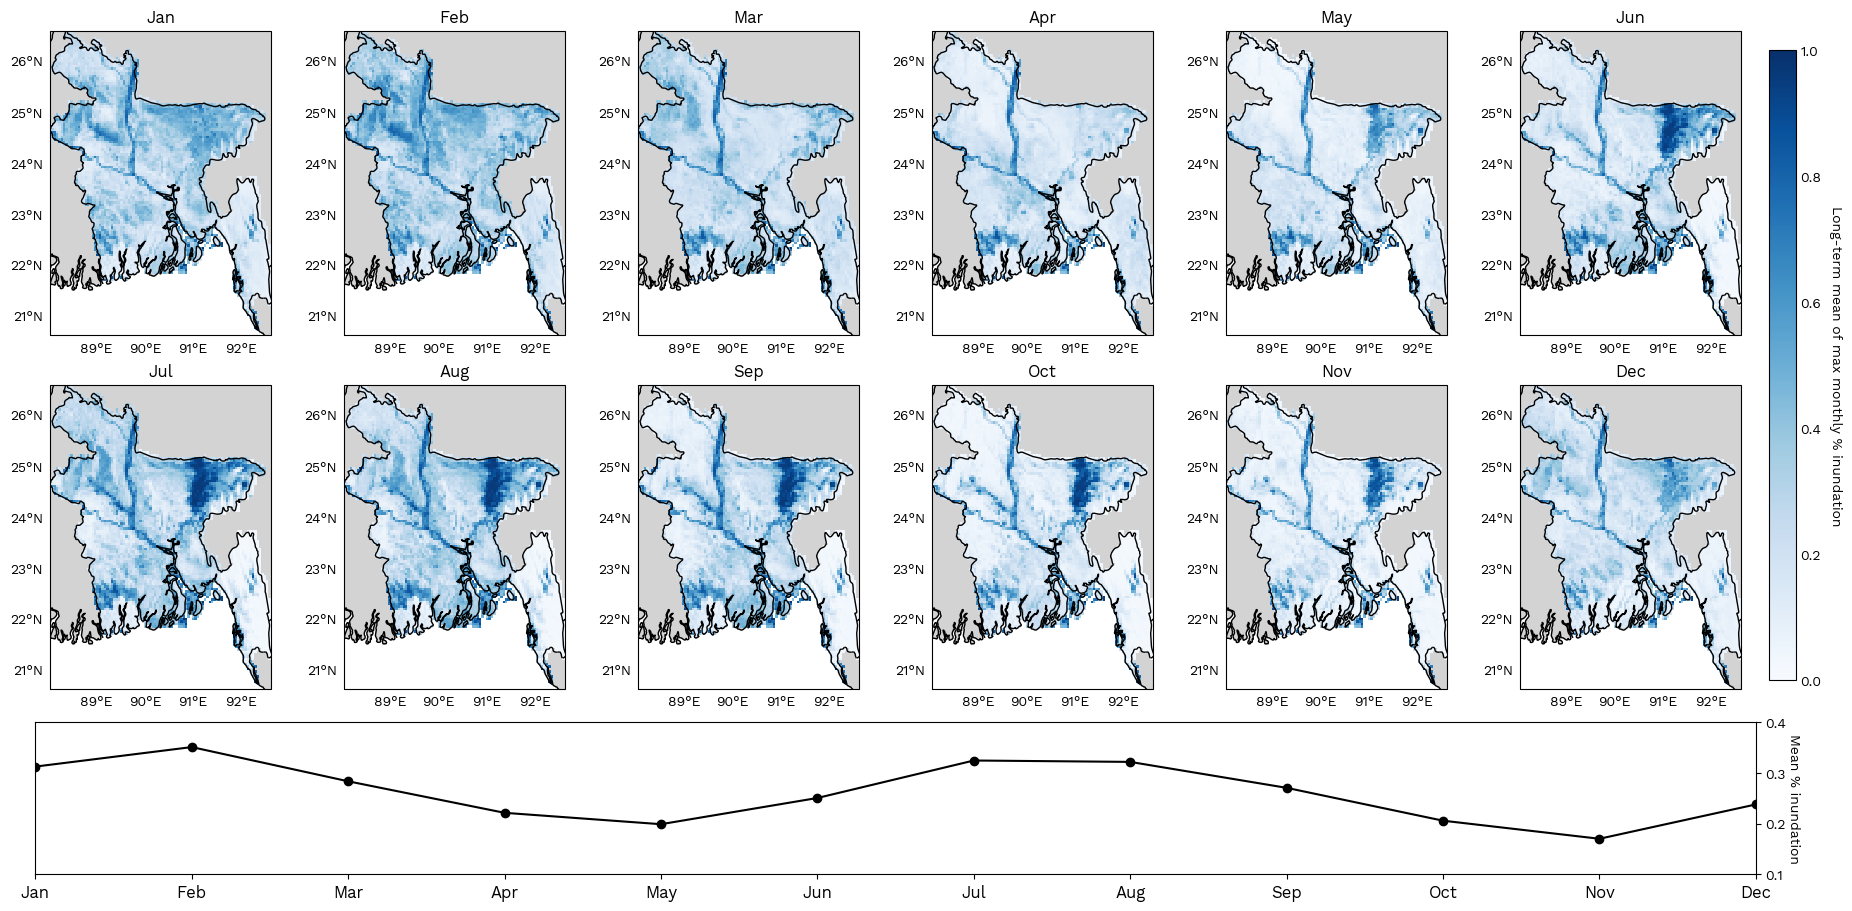

In [55]:
# Define arguments for plotting
plotData=FIAMonthlyClim.transpose('month','lat','lon')
coordsData=FIAMonthlyClim
vmin, vmax, nlevelsCbar = 0, 1, 6
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='Blues'
# levels = np.linspace(vmin, vmax, nlevels)
nToPlot=12
ncolsToPlot=6
nrowsToPlot=math.ceil(nToPlot/ncolsToPlot) + 1 # add one for the time series below
colSize=3
extentBuffer=0
plotExtent= [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Create time series of country totals for subplot - use gridspec to plot below maps
tsData = plotData.mean(dim=["lat", "lon"])
# tsDataMax = plotData.sum(dim=["lat", "lon"])

# # Plot
# fig = plt.figure(constrained_layout=True)
# subfigs = fig.subfigures(2, 1, height_ratios=[3, 1])

# Create a figure with a grid layout
fig = plt.figure(figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True)
gs = gridspec.GridSpec(nrowsToPlot, ncolsToPlot, figure=fig, height_ratios=[2, 2, 1], width_ratios=[1, 1, 1, 1, 1, 1])

# Plot the 12 maps
for i in range(nToPlot):
    row = i // 6
    col = i % 6
    ax = plt.subplot(gs[row, col], projection=ccrs.Miller(central_longitude=centerLon)) #subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)}
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    axplot = plotData[i,:,:].plot.imshow(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, add_colorbar=False, extend=extend)#, levels=levels
    ax.set_title('{0}'.format(monthNames[i]))#, fontsize=16)
    # cb1 = plt.colorbar(axplot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8, extend=extend)
    # cb1.ax.tick_params(size=0)        
# cb = fig.colorbar(axplot, ax=axes.ravel().tolist(), orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8, extend=extend, pad=0.02)
# cb.ax.tick_params(size=0)
# cb.set_label('Long-term mean of total monthly precipitation (mm)', rotation=270, labelpad=10)

# Create a subplot for the time series beneath the maps
ax_ts = plt.subplot(gs[2, :])
ax_ts.plot(tsData, 'ko-', zorder=2)
# ax_ts.plot(tsDataMax, 'bo-', zorder=2)
ax_ts.set_xlim(0,11)
ax_ts.set_ylim(0.1,0.4)
ax_ts.yaxis.tick_right()
ax_ts.yaxis.set_label_position("right")
ax_ts.set_ylabel('Mean % inundation', rotation=270, labelpad=10) 
ax_ts.tick_params(axis='y', which='both', left=False, right=True)
# formatter = FuncFormatter(lambda x, _: '{:.0f}M'.format(x * 1e-6))
# ax_ts.yaxis.set_major_formatter(formatter)
ax_ts.set_xticks(range(nToPlot),monthNames, fontsize=12) 

# Add single cbar
cbar_ax = fig.add_axes([0.98, 0.25, 0.015, 0.7]) 
cb = fig.colorbar(axplot, cax=cbar_ax, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8, extend=extend, pad=0.02)
cb.ax.tick_params(size=0)
cb.set_label('Long-term mean of max monthly % inundation', rotation=270, labelpad=15)

plt.show()

## 2) Compute EOF on the monthly timestep data

In [19]:
FIA=FIAxr.copy()

In [20]:
# Set no data value (in raw data is -9999) to nan
noDataVal=FIA.values[0,0,0]
FIA = FIA.where(FIA!=noDataVal, np.nan)

In [21]:
FIA.shape

(1346, 1040, 985)

### Create monthly max and monsoon season max

In [52]:
# Check gaps of time data
diffs=[]
for i, date in enumerate(imageDates):
    if i!=0:
        diff = date - date0
        diffs.append(diff)
    date0=date

In [53]:
np.unique(diffs)

array([Timedelta('5 days 00:00:00'), Timedelta('6 days 00:00:00'),
       Timedelta('8 days 00:00:00'), Timedelta('16 days 00:00:00'),
       Timedelta('24 days 00:00:00'), Timedelta('32 days 00:00:00')],
      dtype=object)

In [17]:
# Use rolling to get annual max
FIAMonthly_ = FIAMonthlyMax.rolling(time = 12).max(skipna=True)
FIAAnnualMax = FIAMonthly_.where(FIAMonthly_.time.dt.month == 12, drop=True)

# Drop 2001 since it is an incomplete year, with data starting in June
FIAAnnualMax = FIAAnnualMax.drop_isel(time=0)

In [18]:
# Use rolling to get monsoon annual max - monsoon months are June-October inclusive i.e. 5 months
FIAMonthly_ = FIAMonthlyMax.rolling(time = 5).max(skipna=True)
FIAMonsoonMax = FIAMonthly_.where(FIAMonthly_.time.dt.month == 10, drop=True)

### Quick plots of annual monsoon max

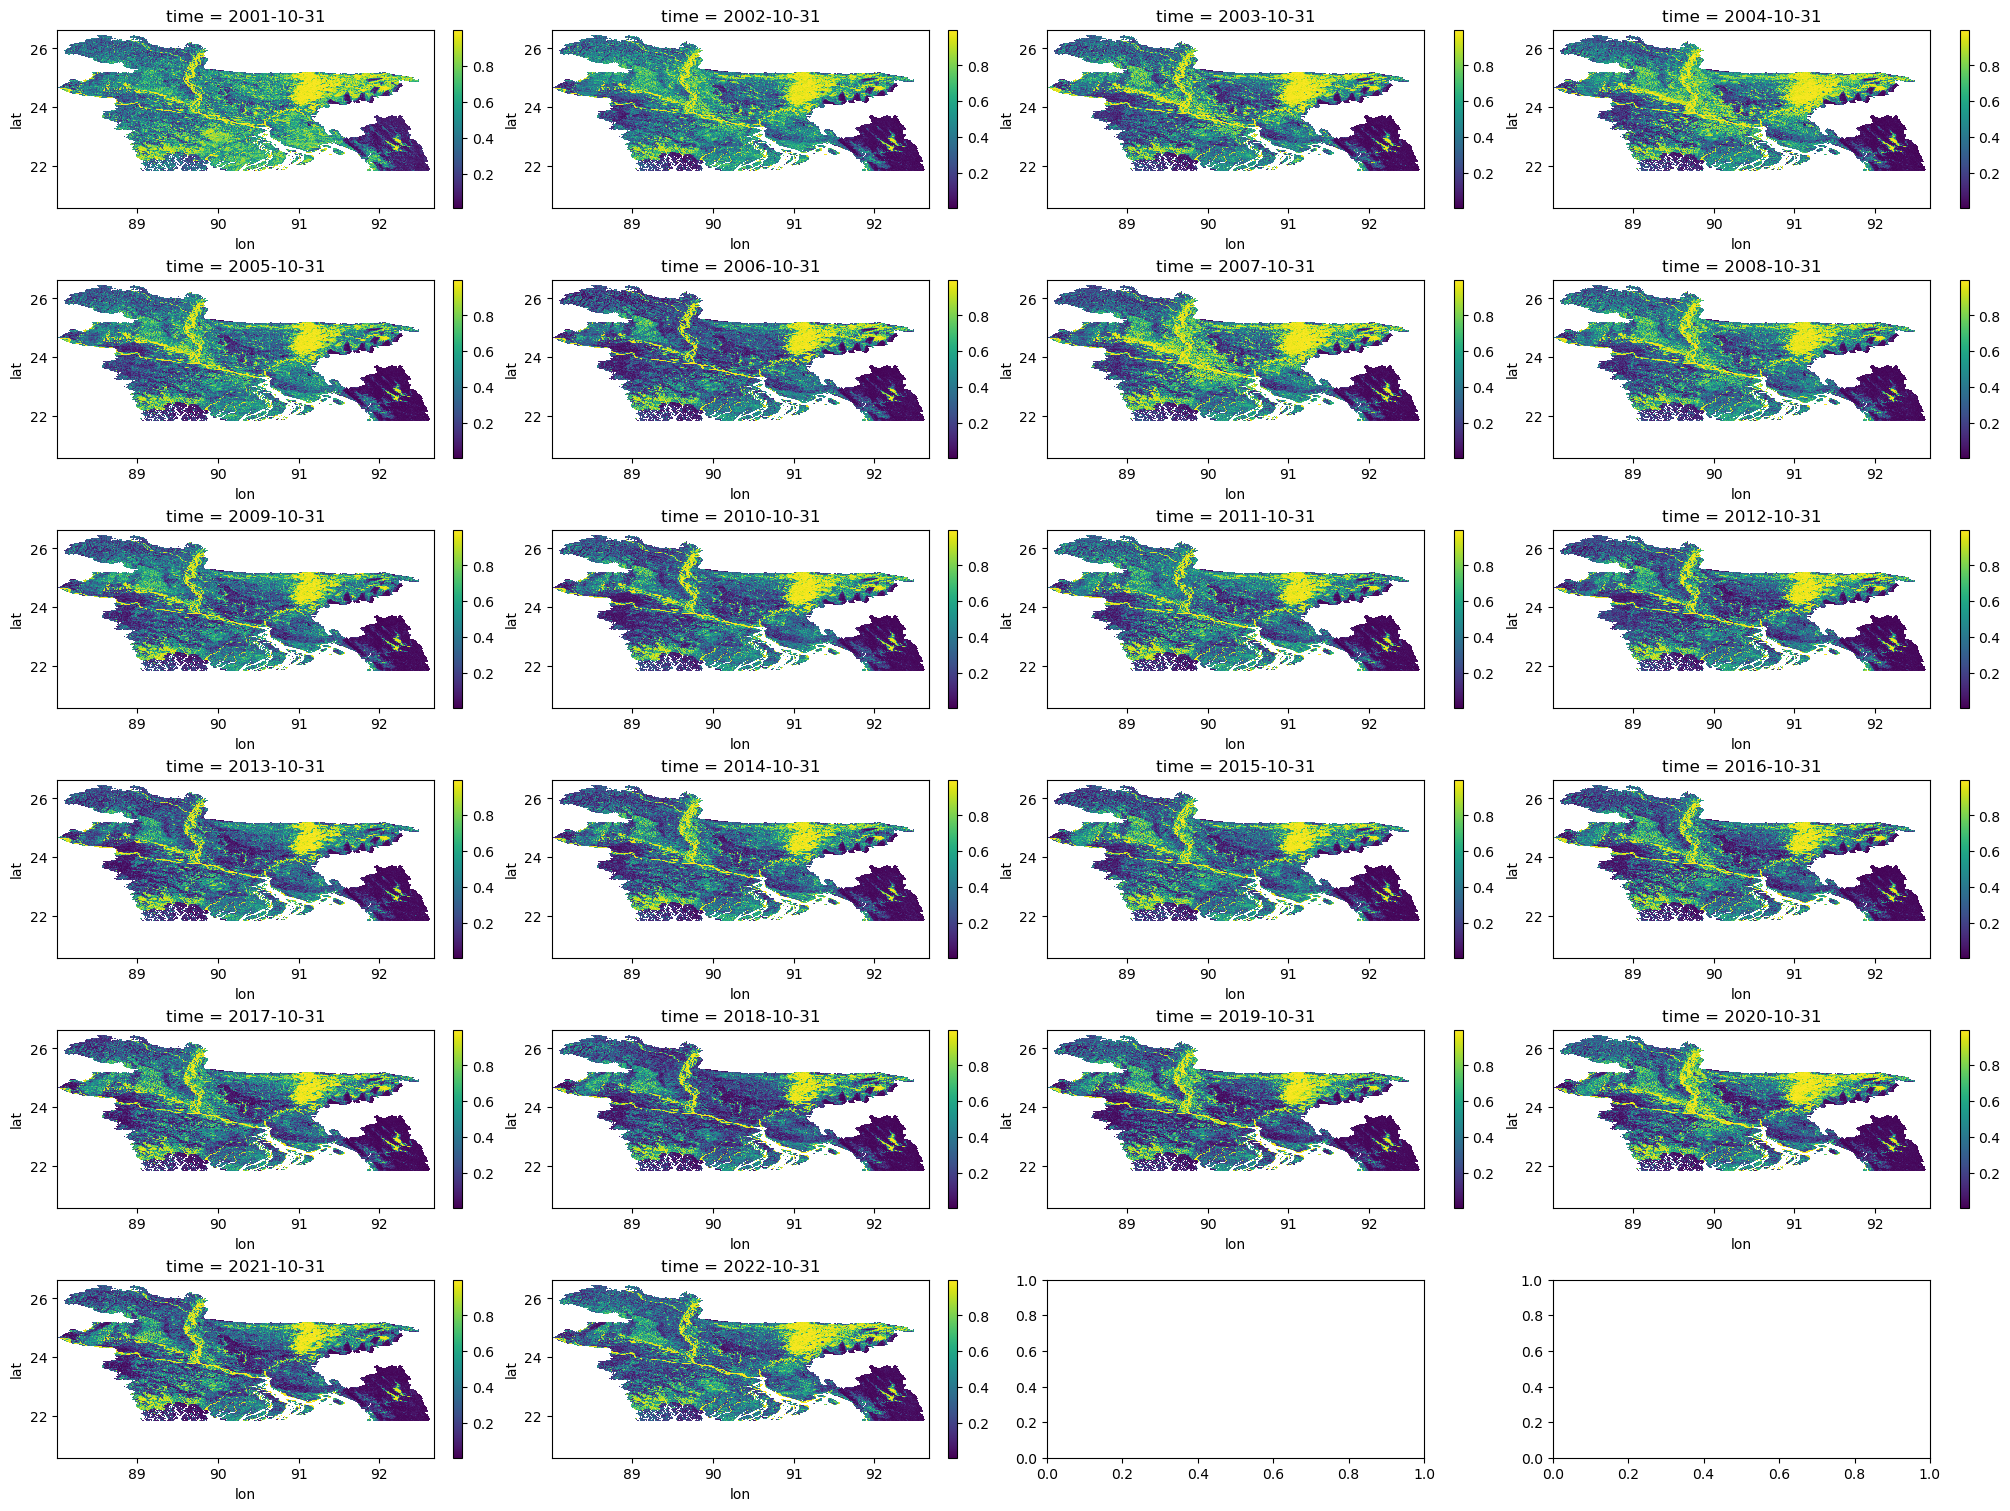

In [94]:
fig, axes = plt.subplots(6,4, figsize=(20,15), constrained_layout=True)

for i, ax in enumerate(axes.ravel()[0:len(FIAMonsoonMax.time)]):
    FIAMonsoonMax[:,:,i].plot(ax=ax, vmin=0, vmax=1)

### Reshape and normalize

In [19]:
# # Reshape from 3D (time, lat, lon) to 2D (time, locs)
# ntime, nrow, ncol = FIAMonsoonMax.shape[2], FIAMonsoonMax.shape[0], FIAMonsoonMax.shape[1]
# nloc=nrow*ncol
# FIA_2D = np.array(FIAMonsoonMax).reshape(ntime, nloc, order='F')

In [36]:
# # Subtract mean and divide by standard deviation at each pixel
# FIAAnom = (FIA_2D - FIA_2D.mean(axis=0)) / FIA_2D.std(axis=0)

In [30]:
# Change time to first dimension
FIAMonsoonMax=FIAMonsoonMax.transpose("time", "lat", "lon")

In [85]:
# Function to reshape, remove locs with missing values
def reshape(data):
    ntime, nrow, ncol = data.shape
    nloc=nrow*ncol
    dataNew = np.array(data).reshape(ntime, nloc)
    print('Shape before removing data with missing vals', dataNew.shape)
    # Remove locs with missing values i.e. only keep pixels which have zero NA values at all timesteps
    noMissing = ~np.isnan(dataNew).any(axis=0)
    dataNew = dataNew[:,noMissing]
    print('Shape after removing data with missing vals', dataNew.shape)
    return dataNew, ntime, nrow, ncol, nloc, noMissing

# Function to normalize - subtract mean and divide by standard deviation at each pixel
def normalize(data):
    anom = (data - data.mean(axis=0)) / data.std(axis=0)
    print(anom[0,:])
    return anom

In [34]:
FIA_2D, ntime, nrow, ncol, nloc, noMissing = reshape(FIAMonsoonMax)
FIAAnom = normalize(FIA_2D)

Shape before removing data with missing vals (22, 1399840)
Shape after removing data with missing vals (22, 590736)


### Perform EOF

In [43]:
# Function to perform EOF
def getEOF(dataAnom, k, nrow, ncol, noMissing):
    U, S, Vt = sp.sparse.linalg.svds(dataAnom, k=k)
    # Sort the eigenmodes
    sort_index = np.argsort(S)[::-1]
    S = S[sort_index]
    U = U[:,sort_index]
    V = Vt.T[:,sort_index]
    # Create the PCs time series
    pcs = dataAnom @ V
    # Create the EOFs with dimensions of the original data
    eofs = np.full((nrow*ncol, S.shape[0]), np.nan) 
    eofs[noMissing,:] = V
    eofs = eofs.reshape([nrow, ncol, S.shape[0]])
    print('EOFs',eofs.shape)
    print('PCs',pcs.shape)
    return eofs, pcs

In [44]:
eofs, pcs = getEOF(FIAAnom, 21, nrow, ncol, noMissing)

EOFs (1346, 1040, 21)
PCs (22, 21)


In [48]:
# Swap sign of the first EOF
eofs[:,:,0]=-eofs[:,:,0]
pcs[:,0]=-pcs[:,0]

In [52]:
print(np.nanmin(eofs), np.nanmax(eofs))

-0.0021218053932040622

### Plot the EOFs

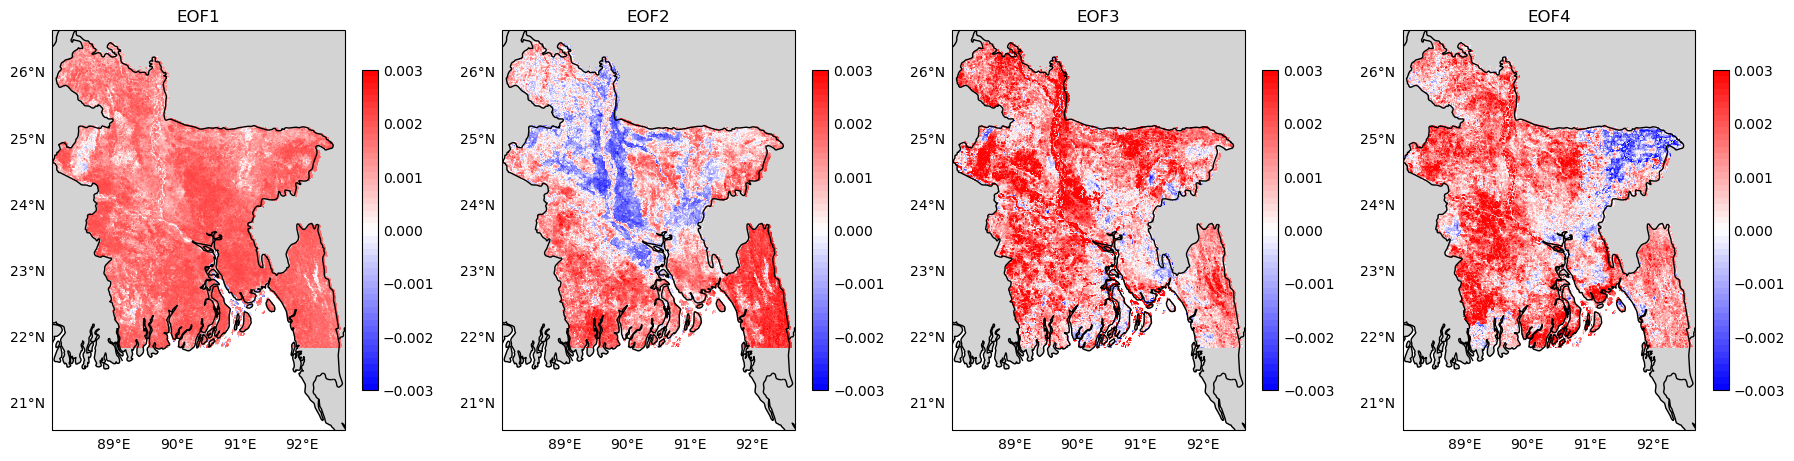

In [81]:
# vmin, vmax, nlevels, nlevelsCbar = -0.03, 0.03, 51, 7
vmin, vmax, nlevels, nlevelsCbar = -0.003, 0.003, 51, 7
cmap='bwr'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=4
ncolsToPlot=4
colSize=4.5

fig, axes = plt.subplots(math.ceil(EOFsToPlot/ncolsToPlot), ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*(math.ceil(EOFsToPlot/ncolsToPlot))), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=90)})
# fig.suptitle('EOFs in Annual Monsoon Max Inundation, 2001-2022')

for i, ax in enumerate(axes.ravel()[:EOFsToPlot]):#

    ax.set_title('EOF{0}'.format(i+1))#, fontsize=16)
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent([FIA.lon.min().values, FIA.lon.max().values, FIA.lat.min().values, FIA.lat.max().values], crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    eofPlot = ax.contourf(FIA.lon, FIA.lat, eofs[:,:,i], cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels) 
    cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar),
                      extend='both', shrink=0.8)
    cb1.ax.tick_params(size=0)
    
    # if i>=EOFsToPlot:
    #     ax.remove()

In [ ]:
# Define data and arguments for plotting
plotData=eofs
coordsData=FIA
titleName='EOF'
vmin, vmax, nlevels, nlevelsCbar = -0.003, 0.003, 51, 7
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='bwr'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=4
ncolsToPlot=4
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, axes = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

for i, ax in enumerate(axes.ravel()):
    ax.set_title('{0}{1}'.format(titleName, i+1))#, fontsize=16)
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData[:,:,i], cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
    cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
    cb1.ax.tick_params(size=0)

### Plot the PCs

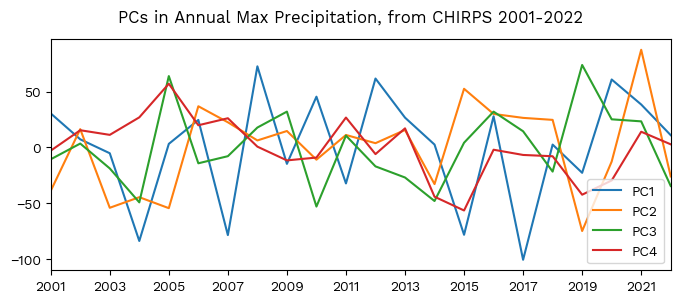

In [259]:
years=[pd.to_datetime(item).year for item in FIAMonsoonMax.time.values]
fig, ax = plt.subplots(figsize=(8,3))
fig.suptitle('PCs in Annual Monsoon Max Inundation, 2001-2022')

for i in range(4):
    ax.plot(years, pcs[:,i], label='PC{}'.format(i+1))
    
ax.set_xlim(min(years), max(years))
ax.set_xticks(range(min(years), max(years), 2), range(min(years), max(years), 2))
ax.legend()

plt.show()

## Repeat EOFs but on coarser (lower resolution) version

In [83]:
resFactor=11
FIAMonsoonMaxCoarse = FIAMonsoonMax.coarsen(lat=resFactor, boundary='trim').mean().coarsen(lon=resFactor, boundary='trim').mean()

In [93]:
print(np.nanmin(FIAMonsoonMaxCoarse), np.nanmax(FIAMonsoonMaxCoarse))

0.014054889441467822 0.9980024248361588


In [86]:
FIA_2DCoarse, ntime, nrowCoarse, ncolCoarse, nlocCoarse, noMissingCoarse = reshape(FIAMonsoonMaxCoarse)
FIAAnomCoarse = normalize(FIA_2DCoarse)

Shape before removing data with missing vals (22, 11468)
Shape after removing data with missing vals (22, 5362)
[0.80671164 0.59960732 1.29757597 ... 4.44113025 4.39456185 4.16354272]


In [88]:
eofsCoarse, pcsCoarse = getEOF(FIAAnomCoarse, 21, nrowCoarse, ncolCoarse, noMissingCoarse)

EOFs (122, 94, 21)
PCs (22, 21)


In [97]:
# # Swap sign of the first EOF
# eofsCoarse[:,:,0]=-eofsCoarse[:,:,0]
# pcsCoarse[:,0]=-pcsCoarse[:,0]

In [98]:
print(np.nanmin(eofsCoarse), np.nanmax(eofsCoarse))

-0.0677634866696121 0.06626582977229732


### Plot the coarse EOFs

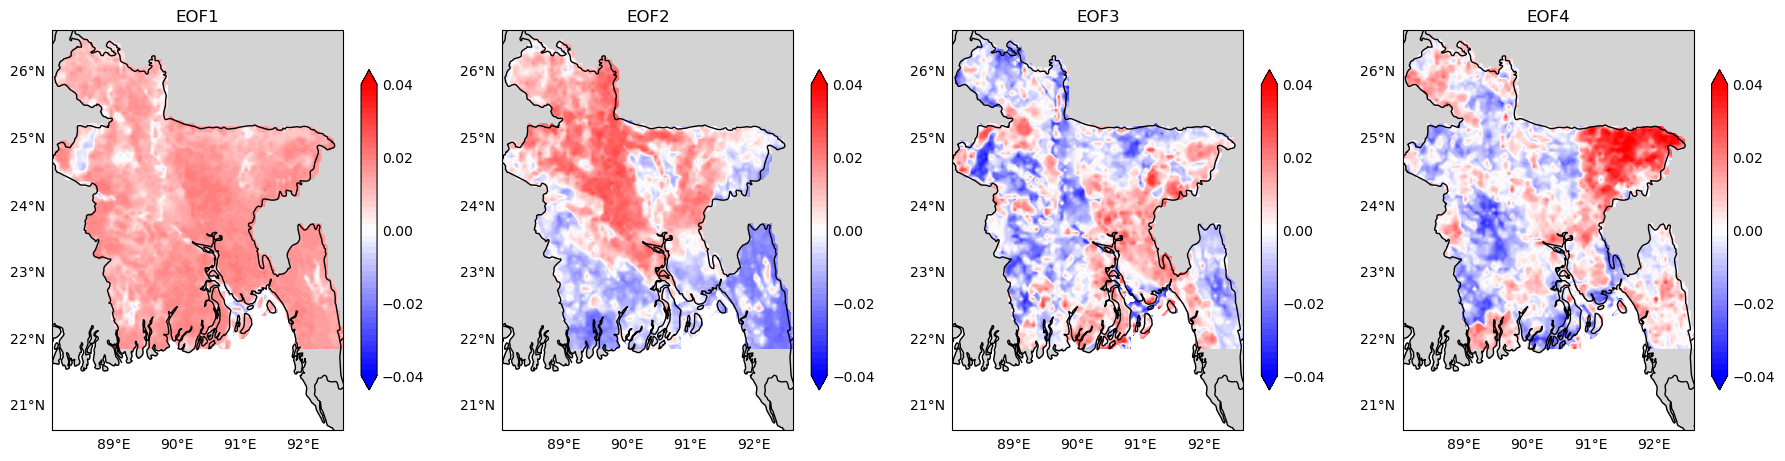

In [103]:
# Define data and arguments for plotting
plotData=eofsCoarse
coordsData=FIAMonsoonMaxCoarse
titleName='EOF'
vmin, vmax, nlevels, nlevelsCbar = -0.04, 0.04, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='bwr'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=4
ncolsToPlot=4
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, axes = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

for i, ax in enumerate(axes.ravel()):
    ax.set_title('{0}{1}'.format(titleName, i+1))#, fontsize=16)
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData[:,:,i], cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
    cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
    cb1.ax.tick_params(size=0)

## Significance testing - perform on the coarse version for computation
Perform rule N red noise and Guassian white noise significance tests

### First, perform EOF with all possible eigen modes, to get full set of eigenvalues

In [106]:
# Function to get all eigenvalues
def getEigenValsFull(anom):
    # Create covariance matrix
    C=np.cov(anom,rowvar=False,ddof=1)
    # Perform SVD for full eigenvectors and values
    U,S,V = np.linalg.svd(C)
    return C, U, S, V

In [107]:
anom=FIAAnomCoarse

In [108]:
C, U, S, V = getEigenValsFull(anom)

In [109]:
S.shape

(5362,)

In [110]:
# Convert eigen values to perfect variance (% variance explained)
SVar = 100 * (S/np.sum(S))

In [111]:
# Define no of Monte Carlo simulations, and confidence interval for significance threshold
iterations=10
sigThresh=95

# Get mean and stdev of data values for conditioning the noise
mu = anom.mean(axis=0)
sigma = anom.std(axis=0)

### Compute eigenvalue variances from Gaussian white noise

In [112]:
# Create array for storing eigenvalues from noise test - uses length of eigenvalues created from the actual data
Ssim = np.full((iterations, len(S)), np.nan)
# Simulate for all iterations
for i in range(iterations):
    # Create matrix for gaussian noise, normalize
    gaussi = np.random.normal(mu, sigma, anom.shape)
    gaussi = (gaussi - gaussi.mean(axis=0)) / gaussi.std(axis=0)
    # Apply SVD on covaraince matrix
    Ci = np.cov(gaussi, rowvar=False, ddof=1)
    Ui,Si,Vi = np.linalg.svd(Ci)
    Ssim[i,:] = Si
# Convert eigen values to perfect variance (% variance explained)
SsimVar = 100 * (Ssim/np.sum(Ssim,axis=1)[:,None])
# Get the %ile value of the eigen values and % variance explained
SsimSig = np.percentile(Ssim, sigThresh, axis=0) 
SsimVarSig = np.percentile(SsimVar, sigThresh, axis=0)

### Compute eigenvalue variances from Red Noise

In [113]:
# Rows and cols to simulate
nrows, ncols = anom.shape 
# Get a mean phi value to use
acf1 = pd.DataFrame(anom).apply(lambda x: x.autocorr())
# Create array for storing eigenvalues from noise test - uses length of eigenvalues created from the actual data
SsimR = np.full((iterations, len(S)), np.nan)

# loop through the j iterations with an inner loop through the i rows of the simulated red noise matrix
for j in range(iterations):
    # Create empty matrix for red noise
    redi = np.full(anom.shape, np.nan)    
    # Mean value and the variance of the random distribution
    c = mu # we have a zero-mean process
    sigma_e = np.sqrt((1 - acf1 ** 2)) # sets the appropriate standard deviation for [0,1] data
    # Set the first value in the array as a random draw with the correct mean and variance
    redi[0,:] = np.array([c + np.random.normal(0, sigma_e, size=ncols)])
    # Inner loop i that goes row-by-row to generate the red noise simulation
    for i in range(1, nrows):
        redi[i,:] = np.array([c + (acf1 * redi[i-1,:]) + np.random.normal(0, sigma_e,size=ncols)])
    # Calculate the covariance and then use svd to get the eigenvalues and eigenvectors
    CRi = np.cov(redi,rowvar=False,ddof=1) # get the covariance of the random matrix
    URi,SRi,VRi = np.linalg.svd(CRi) # factor the covariance matrix into eigenvalues and eigenvectors
    SsimR[j,:] = SRi # save the simulated eigenvalues here so we can use them outside the loop
    
# Convert eigen values to perfect variance (% variance explained)
SsimVarR = 100 * (SsimR/np.sum(SsimR,axis=1)[:,None])
# Get the %ile value of the eigen values and % variance explained
SsimSigR = np.percentile(SsimR, sigThresh, axis=0) 
SsimVarSigR = np.percentile(SsimVarR, sigThresh, axis=0)

### North's rule of thumb test
Based on overlap between the error bars

In [114]:
def northTest(ev, varscaled=False):
    error_factor = np.sqrt(2.0 / len(ev)) # the square root scaling
    # allow for scaling of the eigenvalues by the total variance (sum of the eigenvalues).
    if varscaled:
        error_factor = (error_factor/np.sum(ev)) * 100  # if the eigenvalues provided are actually percent variance, allow for this
    error_range = error_factor * ev # apply the square root scaling to the eigenvalues provided
    return (error_range) # returnt the error ranges
# now call the above function, passing the eigenvalues as input
north_errors = northTest(S)
north_errorsVar = northTest(SVar, varscaled=True)

### Broken stick test

In [115]:
def broken_stick_model(ev):
    # ev is the vector of eigenvalues 
    n = len(ev)
    bsm = np.empty(n)  # Pre-allocate an array
    for i in range(1, n + 1):
        bsm[i - 1] = np.sum(1 / np.arange(i, n + 1)) / n # bsm will sum to 1, it is the fraction of the whole for each segment
    return (bsm)
# Apply Broken Stick Function to our eigenvalues    
bsm = broken_stick_model(S)*100

### Plot the results of the significance test as a scree plot

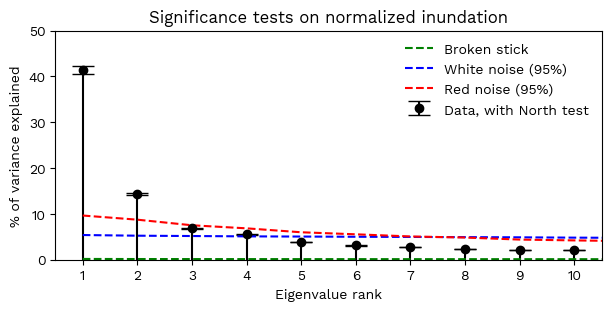

In [125]:
fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)

# Plot eigen values % of variacne explained
nEigToPlot=10
iplotShort=np.arange(1,nEigToPlot+1)
iplot=np.arange(1,len(SVar)+1)
ax.stem(iplotShort, SVar[:nEigToPlot], basefmt=" ", markerfmt='', linefmt='k-')#, label='data eigenvalues')

# North errors
ax.errorbar(iplotShort, SVar[:nEigToPlot], yerr=north_errorsVar[:nEigToPlot], capsize=8, fmt="ko", label='Data, with North test')
# plt.errorbar(iplot, SVar, yerr=north_errors, capsize=8, fmt="ko-", markerfacecolor='none', label='Data, with North test')

# Broken stick
ax.plot(iplot, bsm, linestyle="--", color="g", label='Broken stick')

ax.set_ylim([0,50])
ax.set_xlim([0.5,10.5])

# Monte Carlo approaches - red and white noise
ax.plot(iplot, SsimVarSig, linestyle="--", color="b", label="White noise (95%)") 
ax.plot(iplot, SsimVarSigR, linestyle="--", color="r", label="Red noise (95%)")
ax.legend(frameon=False)
ax.set_xlabel('Eigenvalue rank')
ax.set_ylabel('% of variance explained')
ax.set_title("Significance tests on normalized inundation")
# ax.set_title("Significance tests on normalized " + r"$\bf{inundation}$")#" + str(number) + "
ax.set_xticks([1,2,3,4,5,6,7,8,9,10]);

In [161]:
# # Calculate covariance matrix of the anomalies- too computationally expensive!
# # C = np.cov(FIAAnom, rowvar=False, ddof=1)
# #Unable to allocate 1.99 TiB for an array with shape (522794, 522794) and data type float64

# # Perform SVD on the data (not the covariance matrix)
# # U, S, Vt = sp.sparse.linalg.svds(FIAAnom, k=21)

# # Sort the eigenmodes
# sort_index = np.argsort(S)[::-1]
# S = S[sort_index]
# U = U[:,sort_index]
# V = Vt.T[:,sort_index]

# # Create the PCs time series
# pcs = FIAAnom @ V

# # Create the EOFs with dimensions of the original data
# eofs = np.full((nrow*ncol, S.shape[0]), np.nan) 
# eofs[noMissing,:] = V
# eofs = eofs.reshape([nrow, ncol, S.shape[0]], order='F')

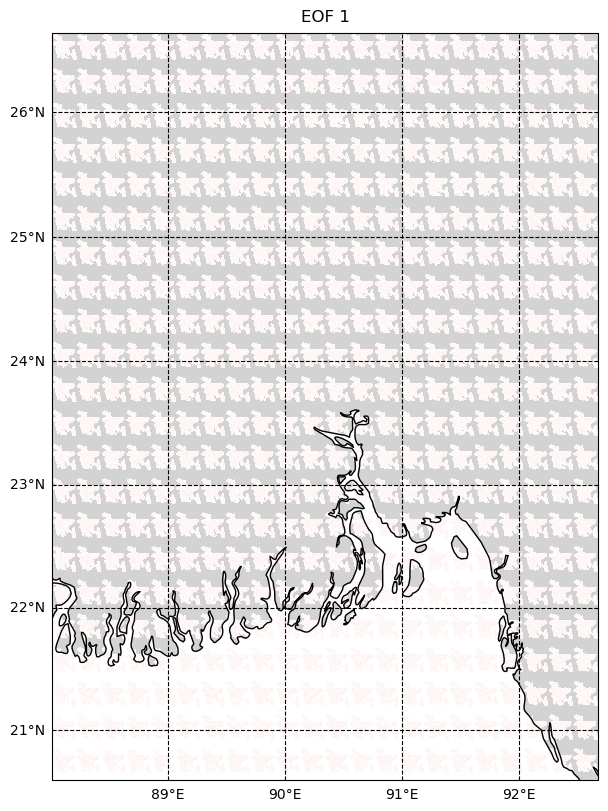

In [248]:
# levels = np.linspace(-0.05, 0.05, 51)

fig, ax = plt.subplots(figsize=(8,8), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=90)})
fig.suptitle('EOF 1')

# EOF1
# ax=axes[0]
# ax.set_title('EOF1', fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.set_extent([FIA.lon.min().values, FIA.lon.max().values, FIA.lat.min().values, FIA.lat.max().values], crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
eof1Plot = ax.contourf(FIA.lon, FIA.lat, eofs[:,:,0], cmap='bwr', transform=ccrs.PlateCarree(), vmin=-0.05, vmax=0.05)#, levels=levels,vmin=-0.05, vmax=0.05,) 
# cb1 = plt.colorbar(eof1Plot, orientation='vertical', ticks=np.linspace(-0.05, 0.05, 11))
